In [1]:
import os
import glob
import pickle 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Catalog of Galaxies

In [2]:
# Apparent V Magnitudes from McConnachie et al. (2012), except Crater II, from Torrealba et al. (2016)

galaxies_path = os.path.join('Periods', 'galaxies.txt')

galaxies_names = ['Galaxy Name', 'Apparent V Magnitude', 'Error in Magnitude']

galaxies_table = pd.read_csv(galaxies_path, sep = ',', header = None, names = galaxies_names, engine = 'python')
galaxies_table = galaxies_table.sort_values('Galaxy Name')

galaxies_table.info()
display(galaxies_table)
galaxies_table.to_csv('Monte Carlo/galaxies.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
Galaxy Name             12 non-null object
Apparent V Magnitude    12 non-null float64
Error in Magnitude      12 non-null float64
dtypes: float64(2), object(1)
memory usage: 384.0+ bytes


,Galaxy Name,Apparent V Magnitude,Error in Magnitude
0,Andromeda I,12.70,0.10
1,Andromeda II,11.70,0.20
2,Andromeda III,14.40,0.30
3,Andromeda XV,14.60,0.30
4,Andromeda XXVIII,15.60,0.90
5,Cetus,13.20,0.20
6,Crater II,12.15,0.02
9,IC 1613,9.20,0.10
7,Leo A,12.40,0.20
8,Leo I,10.00,0.30


# Filter Transformations

In [3]:
def des_to_sdss(g, r, i, z):
    """Computes g - i color in SDSS bands from mean g, r, i, and z magnitudes in DES bands."""
    g_minus_r = (1 / 0.998) * ((g - r) + 0.01)
    i_minus_z = (1 / 0.830) * ((i - z) - 0.01)
    g_minus_i = (g - i) + 0.104 * g_minus_r - 0.256 * i_minus_z + 0.01
    return g_minus_i

def sdss_to_johnson(color):
    """Converts g - i color to V - I color."""
    if color <= 2.1:
        return 0.674 * color + 0.406
    else:
        return 0.674 * color
    
def des_transform(g, r, i, z):
    """Computes V - I color from DES photometric data."""
    return sdss_to_johnson(des_to_sdss(g, r, i, z))    

def calc_wesenheit_des(g, r, i, z):
    """Computes V - I Wesenheit magnitude from DES photometric data."""
    color = des_transform(g, r, i, z)
    g_minus_r = (1 / 0.998) * ((g - r) + 0.01)
    sdss_g = g + 0.104 * g_minus_r - 0.01
    V_minus_g = -0.569 * g_minus_r + 0.021
    johnson_I = (V_minus_g + sdss_g) - color
    return johnson_I - 1.467 * color

def hubble_to_johnson(f606w, f814w):
    """Computes V - I color from Hubble photometric data."""
    color = f606w - f814w
    return (1 / 0.812) * (color + 0.930)

def calc_wesenheit_hubble(f606w, f814w):
    """Computes V - I Wesenheit magnitude from Hubble photometric data."""
    f606w = f606w - 26.168
    f814w = f814w - 25.501
    color = hubble_to_johnson(f606w, f814w)
    johnson_I = f814w + 25.480 + 0.024 * color
    return johnson_I - 1.467 * color

def convergence(mag_1, mag_2, corr_1, corr_2, c0_1, c0_2, c1_1, c1_2, a):
    """Computes Wesenheit magnitude from Hubble photometric data."""
    mag_1 = mag_1 - corr_1
    mag_2 = mag_2 - corr_2
    initial_color = mag_1 - mag_2
    guess_1 = mag_1 + c0_1 + c1_1 * initial_color
    guess_2 = mag_2 + c0_2 + c1_2 * initial_color
    new_color = guess_1 - guess_2
    while abs(new_color - initial_color) > 0.001:
        guess_1 = mag_1 + c0_1 + c1_1 * initial_color
        guess_2 = mag_2 + c0_2 + c1_2 * initial_color
        initial_color = new_color
        new_color = guess_1 - guess_2
    guess_2 = mag_2 + c0_2 + c1_2 * initial_color
    return guess_2 - a * new_color

In [4]:
def convert_table(file, columns, usecols = None, convert = '', sep = '\s{1,}', impute = False):
    """Convert photometric data to desired format for MCMC model."""
    
    if usecols is not None:
        pulsation = pd.read_csv(file, sep = sep, header = None, names = columns, engine = 'python', usecols = usecols)
    else:
        pulsation = pd.read_csv(file, sep = sep, header = None, names = columns, engine = 'python')

    if convert == 'des':
        for filt in ['g', 'r', 'i', 'z']:
            pulsation[f'{filt} Magnitude'] = pulsation[f'{filt} Magnitude'].astype('float64')
            
        wesenheit = []
        for index, row in pulsation.iterrows():
            wesenheit.append(calc_wesenheit_des(row['g Magnitude'], row['r Magnitude'], row['i Magnitude'], row['z Magnitude']))
        pulsation['Wesenheit Magnitude'] = np.array(wesenheit)
         
    elif convert == 'hubble':
        pulsation['Wesenheit Magnitude'] = calc_wesenheit_hubble(pulsation['F606W Magnitude'], pulsation['F814W Magnitude'])
    
    else:
        pulsation['Wesenheit Magnitude'] = (pulsation['I Magnitude'] - 1.467  * 
                                            (pulsation['V Magnitude'] - pulsation['I Magnitude']))
        
    lin_reg = pulsation[['Star', 'Type', 'Period (Days)', 'Wesenheit Magnitude']]
    
    if impute:
        lin_reg = lin_reg[lin_reg['Period (Days)'] != '---']
    lin_reg = lin_reg.astype({'Period (Days)' : 'float64'})
    
    lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03
    lin_reg['Log Period'] = np.log10(lin_reg['Period (Days)'])
    
    graph_tab = lin_reg.rename({'Type' : 'Variable Type'}, axis = 1)
    
    lin_reg = lin_reg[(lin_reg['Type'] == 'ab') | (lin_reg['Type'] == 'RRab')].reset_index().drop(['index', 'Type'], axis = 1)
    
    num_stars = len(lin_reg['Star'].unique())
    lookup = dict(zip(lin_reg['Star'].unique(), range(num_stars)))
    lin_reg['Star Code'] = lin_reg['Star'].replace(lookup).values
    
    lin_reg = lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]
    lin_reg = lin_reg.reset_index().drop('index', axis = 1)
    
    return graph_tab, lin_reg

# Application to Andromeda Satellites

In [5]:
path = 'Andromeda/J_ApJ_850_137'
pulsation_data = glob.glob(os.path.join(path, 'd4*.dat'))

hubble_names = ['Galaxy', 'Star', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Degrees)', 'Dec (Minutes)', 
                  'Dec (Seconds)', 'Period (Days)', 'Magnitude (F475W)', 'Amplitude (F475W)', 'Magnitude (F814W)', 
                  'Amplitude (F814W)', 'Magnitude (B-Band)', 'Amplitude (B-Band)', 'Magnitude (V-Band)', 'Amplitude (V-Band)', 
                  'Magnitude (Ic-Band)', 'Amplitude (Ic-Band)', 'Variable Type', 'Camera']

hubble_pulsation = pd.concat((pd.read_csv(file, sep = '\s{1,}', header = None, names = hubble_names, engine = 'python') 
                              for file in pulsation_data)).sort_values(by = ['Galaxy', 'Star'])

hubble_pulsation['Star'] = hubble_pulsation['Star'].str.replace('-', '')
hubble_pulsation.head()

,Galaxy,Star,RA (Hour),RA (Minutes),RA (Seconds),Dec (Degrees),Dec (Minutes),Dec (Seconds),Period (Days),Magnitude (F475W),...,Magnitude (F814W),Amplitude (F814W),Magnitude (B-Band),Amplitude (B-Band),Magnitude (V-Band),Amplitude (V-Band),Magnitude (Ic-Band),Amplitude (Ic-Band),Variable Type,Camera
0,AndI,V001,0,45,9.233,37,58,47.19,0.569,25.532,...,24.692,0.574,25.657,1.137,25.266,0.915,24.677,0.580,RRab,WFC3
1,AndI,V002,0,45,9.646,37,59,48.86,0.567,25.505,...,24.737,0.358,25.613,0.669,25.251,0.436,24.719,0.360,RRab,WFC3
2,AndI,V003,0,45,9.819,37,59,32.31,0.296,25.329,...,24.831,0.091,25.398,0.392,25.159,0.207,24.819,0.097,RRc,WFC3
3,AndI,V004,0,45,10.116,37,58,44.43,0.598,25.322,...,24.607,0.699,25.415,1.605,25.103,0.949,24.599,0.669,RRab,WFC3
4,AndI,V005,0,45,10.429,37,58,56.47,0.585,25.557,...,24.733,0.608,25.680,0.864,25.276,0.660,24.722,0.576,RRab,WFC3


In [6]:
hubble_lin_reg = hubble_pulsation[['Galaxy', 'Star', 'Magnitude (B-Band)', 'Magnitude (V-Band)', 'Magnitude (Ic-Band)',
                                   'Variable Type']]

hubble_lin_reg['Wesenheit Magnitude'] = hubble_lin_reg['Magnitude (Ic-Band)'] - 1.467 * (hubble_lin_reg['Magnitude (V-Band)'] - 
                                                                                         hubble_lin_reg['Magnitude (Ic-Band)'])

hubble_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

hubble_lin_reg['Log Period'] = np.log10(hubble_pulsation['Period (Days)'])

hubble_lin_reg = hubble_lin_reg[['Galaxy', 'Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                                 'Log Period', 'Variable Type']]

hubble_lin_reg = hubble_lin_reg[hubble_lin_reg['Galaxy'] != 'AndXVI']

hubble_lin_reg.head()

,Galaxy,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Variable Type
0,AndI,V001,23.812937,0.03,-0.244888,RRab
1,AndI,V002,23.938556,0.03,-0.246417,RRab
2,AndI,V003,24.320220,0.03,-0.528708,RRc
3,AndI,V004,23.859632,0.03,-0.223299,RRab
4,AndI,V005,23.909282,0.03,-0.232844,RRab


In [7]:
and_galaxies = hubble_lin_reg['Galaxy'].unique()
graph_tabs = []

for galaxy in and_galaxies:
    graph_tabs.append(hubble_lin_reg[hubble_lin_reg['Galaxy'] == galaxy])

[and_one_graph_tab, and_two_graph_tab, and_three_graph_tab, and_fifteen_graph_tab, and_twenty_eight_graph_tab] = graph_tabs
print(and_galaxies)

['AndI' 'AndII' 'AndIII' 'AndXV' 'AndXXVIII']


In [8]:
hubble_lin_reg = hubble_lin_reg[hubble_lin_reg['Variable Type'] == 'RRab']
hubble_lin_reg = hubble_lin_reg.drop('Variable Type', axis = 1)

hubble_lin_reg.head()

,Galaxy,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period
0,AndI,V001,23.812937,0.03,-0.244888
1,AndI,V002,23.938556,0.03,-0.246417
3,AndI,V004,23.859632,0.03,-0.223299
4,AndI,V005,23.909282,0.03,-0.232844
7,AndI,V008,23.537866,0.03,-0.101824


In [9]:
def gen_hubble_lin_reg(galaxy, file):
    """Generates linear regression table for an Andromeda satellite."""
    lin_reg = hubble_lin_reg[hubble_lin_reg['Galaxy'] == galaxy].reset_index().drop(['index', 'Galaxy'], axis = 1)
    num_stars = len(lin_reg['Star'].unique())
    lookup = dict(zip(lin_reg['Star'].unique(), range(num_stars)))
    lin_reg['Star Code'] = lin_reg['Star'].replace(lookup).values
    lin_reg.to_csv(f'Monte Carlo/{file}_mcmc.csv', index = False)
    return lin_reg

In [10]:
file_names = ['and_one', 'and_two', 'and_three', 'and_fifteen', 'and_twenty_eight']

for pair in list(zip(and_galaxies, file_names)):
    lin_reg = gen_hubble_lin_reg(*pair)
    display(lin_reg.head())

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.812937,0.03,-0.244888,0
1,V002,23.938556,0.03,-0.246417,1
2,V004,23.859632,0.03,-0.223299,2
3,V005,23.909282,0.03,-0.232844,3
4,V008,23.537866,0.03,-0.101824,4


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V002,23.438018,0.03,-0.221126,0
1,V003,23.380140,0.03,-0.204120,1
2,V004,23.330531,0.03,-0.178486,2
3,V005,23.238607,0.03,-0.114074,3
4,V006,23.318480,0.03,-0.229148,4


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V002,23.584861,0.03,-0.190440,0
1,V003,23.633678,0.03,-0.183759,1
2,V004,23.710404,0.03,-0.203426,2
3,V006,23.704475,0.03,-0.202732,3
4,V007,23.432942,0.03,-0.151195,4


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.931505,0.03,-0.298432,0
1,V002,23.682079,0.03,-0.209012,1
2,V003,23.756759,0.03,-0.231362,2
3,V005,23.718749,0.03,-0.262013,3
4,V007,23.608541,0.03,-0.201349,4


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.773470,0.03,-0.192465,0
1,V005,23.741597,0.03,-0.247952,1
2,V006,23.794277,0.03,-0.267606,2
3,V007,23.550130,0.03,-0.166853,3
4,V010,23.894891,0.03,-0.292430,4


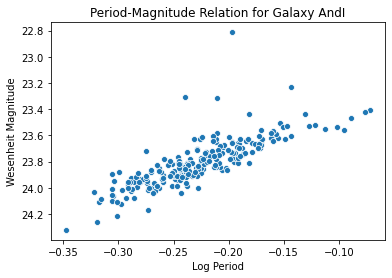

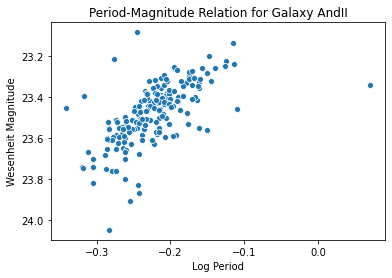

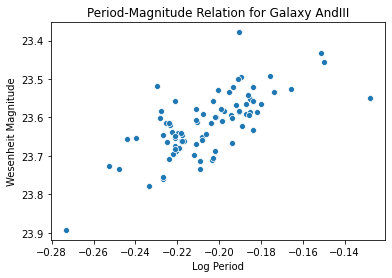

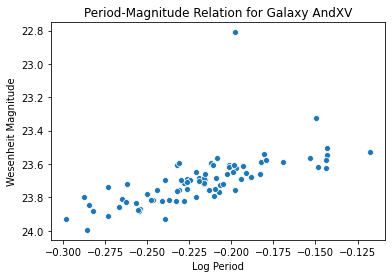

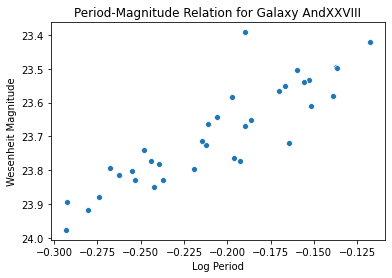

In [11]:
for gal in and_galaxies:
    plt.figure()
    hub_filtered = hubble_lin_reg[(hubble_lin_reg['Galaxy'] == gal)]
    sns.scatterplot(data = hub_filtered, x = 'Log Period', y = 'Wesenheit Magnitude')
    plt.gca().invert_yaxis()
    plt.title(f'Period-Magnitude Relation for Galaxy {gal}');

# Application to Sculptor 

In [12]:
sculptor_path = os.path.join('Sculptor/J_MNRAS_462_4349', 'table4.dat')

sculptor_names = ['Star', 'Name 1', 'Name 2', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Degrees)', 'Dec (Minutes)', 
                  'Dec (Seconds)', 'Period (Days)', 'Uncertainty Flag on Period', 'Mean Magnitude (B)', 'Mean Magnitude (V)', 
                  'Mean Magnitude (I)', 'Amplitude (B)', 'Amplitude (V)', 'Amplitude (I)', 'Quality Flag 1', 'Quality Flag 2',
                  'Variable Type']

sculptor_pulsation = pd.read_csv(sculptor_path, sep = '\s{1,}', header = None, names = sculptor_names, engine = 'python', 
                                 usecols = [i for i in range(21)])

sculptor_pulsation = sculptor_pulsation.replace({"--" : np.nan, "----" : np.nan, "-----" : np.nan})
sculptor_pulsation.head()

,Star,Name 1,Name 2,RA (Hour),RA (Minutes),RA (Seconds),Dec (Degrees),Dec (Minutes),Dec (Seconds),Period (Days),Uncertainty Flag on Period,Mean Magnitude (B),Mean Magnitude (V),Mean Magnitude (I),Amplitude (B),Amplitude (V),Amplitude (I),Quality Flag 1,Quality Flag 2,Variable Type
0,scl-CEMV001,V461,NaN,0,55,21.02,-33,41,1.5,0.420876,::,20.150,19.830,19.460,0.900,0.630,0.000,1,0,RRab
1,scl-CEMV002,NaN,NaN,0,56,9.15,-33,29,20.1,0.305970,NaN,20.326,20.163,19.840,0.298,0.254,0.168,0,1,RRc
2,scl-CEMV005,NaN,NaN,0,56,38.94,-33,24,32.4,0.309746,NaN,20.260,20.086,19.778,0.494,0.359,0.165,0,1,RRc
3,scl-CEMV006,NaN,NaN,0,56,48.78,-33,31,16.3,0.332111,NaN,20.333,20.117,19.738,0.568,0.479,0.401,0,1,RRc
4,scl-CEMV008,NaN,NaN,0,57,4.83,-33,45,20.6,0.281318,NaN,20.357,20.047,19.570,0.881,0.576,0.485,2,0,RRc


In [13]:
sculptor_lin_reg = sculptor_pulsation[['Star', 'Mean Magnitude (B)', 'Mean Magnitude (V)', 
                                       'Mean Magnitude (I)', 'Variable Type']]

sculptor_lin_reg['Wesenheit Magnitude'] = (sculptor_lin_reg['Mean Magnitude (I)'] - 1.467 * 
                                           (sculptor_lin_reg['Mean Magnitude (V)'] - sculptor_lin_reg['Mean Magnitude (I)']))

sculptor_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

sculptor_lin_reg['Log Period'] = np.log10(sculptor_pulsation['Period (Days)'])

sculptor_graph_tab = sculptor_lin_reg.copy()

sculptor_lin_reg = sculptor_lin_reg[(sculptor_lin_reg['Variable Type'] == 'RRab') & (sculptor_lin_reg['Log Period'] < 0) 
                                    & (sculptor_lin_reg['Wesenheit Magnitude'] > 18.5)]

num_stars = len(sculptor_lin_reg['Star'].unique())
sculptor_lookup = dict(zip(sculptor_lin_reg['Star'].unique(), range(num_stars)))
sculptor_lin_reg['Star Code'] = sculptor_lin_reg['Star'].replace(sculptor_lookup).values

sculptor_lin_reg = sculptor_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                                     'Log Period', 'Star Code']]

sculptor_lin_reg = sculptor_lin_reg.reset_index().drop('index', axis = 1)
display(sculptor_lin_reg.head())
sculptor_lin_reg.to_csv('Monte Carlo/sculptor_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,scl-CEMV001,18.917210,0.03,-0.375846,0
1,scl-CEMV015,18.749754,0.03,-0.180738,1
2,scl-CEMV018,18.817292,0.03,-0.237532,2
3,scl-CEMV021,18.656998,0.03,-0.172550,3
4,scl-CEMV022,18.801490,0.03,-0.236795,4


In [14]:
sculptor_graph_tab['Outlier'] = ~((sculptor_graph_tab['Log Period'] < 0) & (sculptor_graph_tab['Wesenheit Magnitude'] > 18.5))
display(sculptor_graph_tab.head())

,Star,Mean Magnitude (B),Mean Magnitude (V),Mean Magnitude (I),Variable Type,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,scl-CEMV001,20.150,19.830,19.460,RRab,18.917210,0.03,-0.375846,False
1,scl-CEMV002,20.326,20.163,19.840,RRc,19.366159,0.03,-0.514320,False
2,scl-CEMV005,20.260,20.086,19.778,RRc,19.326164,0.03,-0.508994,False
3,scl-CEMV006,20.333,20.117,19.738,RRc,19.182007,0.03,-0.478716,False
4,scl-CEMV008,20.357,20.047,19.570,RRc,18.870241,0.03,-0.550802,False


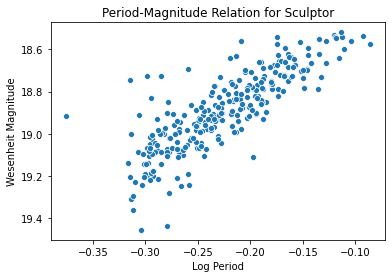

In [15]:
plt.figure()
sns.scatterplot(data = sculptor_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Sculptor');

# Application to Crater II

In [16]:
crater_path = os.path.join('Crater II', 'crater_pulsation.csv')

crater_names = ['Star', 'RA', 'Dec', 'Period (Days)', 'Mean Magnitude (B)', 'Mean Amplitude (B)', 'Mean Magnitude (V)', 
                'Mean Amplitude (V)', 'Mean Magnitude (I)', 'Mean Amplitude (I)', 'Type', 'Period (Joo)', 'Notes']

crater_pulsation = pd.read_csv(crater_path, header = None, names = crater_names)
crater_pulsation.head()

,Star,RA,Dec,Period (Days),Mean Magnitude (B),Mean Amplitude (B),Mean Magnitude (V),Mean Amplitude (V),Mean Magnitude (I),Mean Amplitude (I),Type,Period (Joo),Notes
0,V001,11:48:46.94,−18:37:28.8,0.7633058,20.925,0.984,20.553,0.820,19.950,0.503,Peculiar,0.7633,NaN
1,V002,11:48:59.49,−18:10: 9.8,0.6043024,21.432,0.913,20.966,0.759,20.406,0.546,RRab,0.6053,NaN
2,V003,11:48:38.77,−18:31:40.2,0.6009024,21.217,1.019,20.920,0.834,20.349,0.515,RRab,0.6009,NaN
3,V004,11:48:51.17,−18:16:34.1,0.4091809,21.260,0.477,20.906,0.470,20.403,0.218,RRc,0.4189,NaN
4,V005,11:48:51.89,−18:31:56.7,0.5989511,21.227,1.229,20.904,0.966,20.335,0.575,RRab,0.5989,NaN


In [17]:
crater_lin_reg = crater_pulsation[['Star', 'Mean Magnitude (B)', 'Mean Magnitude (V)', 'Mean Magnitude (I)', 'Type']]

crater_lin_reg['Star'] = crater_lin_reg['Star'].str.strip()

crater_lin_reg = crater_lin_reg.astype({'Mean Magnitude (B)' : 'float64', 'Mean Magnitude (V)' : 'float64', 
                                        'Mean Magnitude (I)' : 'float64'})

crater_lin_reg['Type'] = crater_lin_reg['Type'].str.strip()

crater_lin_reg['Wesenheit Magnitude'] = (crater_lin_reg['Mean Magnitude (I)'] - 1.467 * 
                                         (crater_lin_reg['Mean Magnitude (V)'] - crater_lin_reg['Mean Magnitude (I)']))

crater_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

crater_lin_reg['Log Period'] = np.log10(crater_pulsation['Period (Days)'].astype('float64'))

crater_graph_tab = crater_lin_reg.rename({'Type' : 'Variable Type'}, axis = 1)

crater_lin_reg = crater_lin_reg[(crater_lin_reg['Type'] == 'RRab')]

num_stars = len(crater_lin_reg['Star'].unique())
crater_lookup = dict(zip(crater_lin_reg['Star'].unique(), range(num_stars)))
crater_lin_reg['Star Code'] = crater_lin_reg['Star'].replace(crater_lookup).values

crater_lin_reg = crater_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                                 'Log Period', 'Star Code']]

crater_lin_reg = crater_lin_reg.reset_index().drop('index', axis = 1)
display(crater_lin_reg.head())

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V002,19.584480,0.03,-0.218746,0
1,V003,19.511343,0.03,-0.221196,1
2,V005,19.500277,0.03,-0.222609,2
3,V008,19.421866,0.03,-0.187286,3
4,V010,19.278521,0.03,-0.213724,4


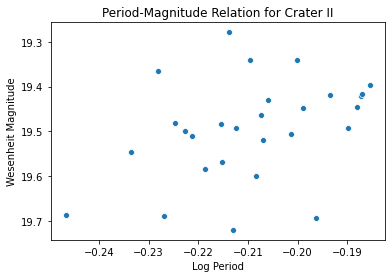

In [18]:
plt.figure()
sns.scatterplot(data = crater_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Crater II');

In [19]:
vivas_periods = pd.read_csv('Crater II/crater_periods_new.csv')

filtered_vivas = vivas_periods[vivas_periods['Type'] == 'ab'].reset_index().drop(['index'], axis = 1)
filtered_vivas = filtered_vivas[filtered_vivas['Star'].isin(crater_lin_reg['Star'].unique())]
filtered_vivas = filtered_vivas.iloc[:, :2]

filtered_vivas.info()
filtered_vivas.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 68
Data columns (total 2 columns):
Star             28 non-null object
Period (Days)    28 non-null float64
dtypes: float64(1), object(1)
memory usage: 672.0+ bytes


,Star,Period (Days)
0,V002,0.60442
1,V003,0.60078
2,V005,0.59900
4,V008,0.64982
6,V010,0.62107


In [20]:
vivas_log_periods = np.array(np.log10(filtered_vivas['Period (Days)']))
crater_lin_reg.loc[:, 'Log Period'] = vivas_log_periods
display(crater_lin_reg.head())
crater_lin_reg.to_csv('Monte Carlo/crater_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V002,19.584480,0.03,-0.218661,0
1,V003,19.511343,0.03,-0.221285,1
2,V005,19.500277,0.03,-0.222573,2
3,V008,19.421866,0.03,-0.187207,3
4,V010,19.278521,0.03,-0.206859,4


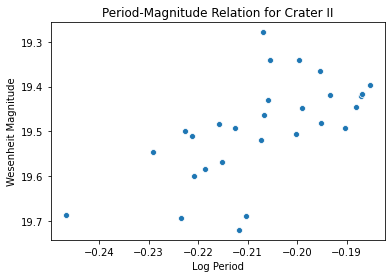

In [21]:
plt.figure()
sns.scatterplot(data = crater_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Crater II');

In [22]:
filt_vivas_graph = vivas_periods[vivas_periods['Star'].isin(crater_graph_tab['Star'].unique())]
filt_vivas_graph = filt_vivas_graph.iloc[:, :2]
vivas_log_periods_graph = np.array(np.log10(filt_vivas_graph['Period (Days)']))
crater_graph_tab = crater_graph_tab[crater_graph_tab['Star'].isin(filt_vivas_graph['Star'].unique())]
crater_graph_tab.loc[:, 'Log Period'] = vivas_log_periods_graph
crater_graph_tab.head()

,Star,Mean Magnitude (B),Mean Magnitude (V),Mean Magnitude (I),Variable Type,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period
0,V001,20.925,20.553,19.950,Peculiar,19.065399,0.03,-0.117231
1,V002,21.432,20.966,20.406,RRab,19.584480,0.03,-0.218661
2,V003,21.217,20.920,20.349,RRab,19.511343,0.03,-0.221285
3,V004,21.260,20.906,20.403,RRc,19.665099,0.03,-0.380375
4,V005,21.227,20.904,20.335,RRab,19.500277,0.03,-0.222573


# Application to IC1613

In [23]:
ic_path = os.path.join('IC1613', 'apj335928t4_mrt.txt')

ic_names = ['Star', 'Type', 'RA (Hour)', 'RA (Min)', 'RA (Sec)', 'Dec (Deg)', 'Dec (Min)', 'Dec (Sec)',
            'Uncertainty Flag', 'Period (Days)', 'Log Period (Days)', 'F475W Magnitude', 'F475W Amplitude', 
            'F814W Magnitude', 'F814W Amplitude', 'Color', 'B Magnitude', 'B Amplitude', 
            'V Magnitude', 'V Amplitude', 'I Magnitude', 'I Amplitude']

ic_graph_tab, ic_lin_reg = convert_table(ic_path, ic_names)

In [24]:
display(ic_lin_reg.head())
ic_lin_reg.to_csv('Monte Carlo/ic_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.823236,0.03,-0.227678,0
1,V005,24.018068,0.03,-0.315155,1
2,V007,23.581211,0.03,-0.175224,2
3,V012,23.678972,0.03,-0.193142,3
4,V013,23.686114,0.03,-0.186419,4


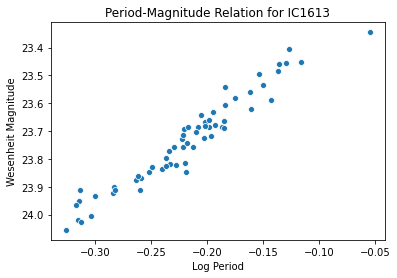

In [25]:
plt.figure()
sns.scatterplot(data = ic_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for IC1613');

# Application to Cetus and Tucana

In [26]:
cetus_path = os.path.join('Cetus', 'apj298915t7_mrt.txt')

cetus_names = ['Star', 'Type', 'RA (Hour)', 'RA (Min)', 'RA (Sec)', 'Dec (Deg)', 'Dec (Min)', 'Dec (Sec)',
               'Uncertainty Flag', 'Period (Days)', 'Log Period (Days)', 'F475W Magnitude', 'F475W Amplitude', 
               'F814W Magnitude', 'F814W Amplitude', 'Color', 'B Magnitude', 'B Amplitude', 
               'V Magnitude', 'V Amplitude', 'I Magnitude', 'I Amplitude']

cetus_graph_tab, cetus_lin_reg = convert_table(cetus_path, cetus_names, impute = True)

In [27]:
display(cetus_lin_reg.head())
cetus_lin_reg.to_csv('Monte Carlo/cetus_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.609409,0.03,-0.177832,0
1,V003,23.719419,0.03,-0.228413,1
2,V004,23.631541,0.03,-0.195179,2
3,V005,23.782891,0.03,-0.221126,3
4,V006,23.502668,0.03,-0.098542,4


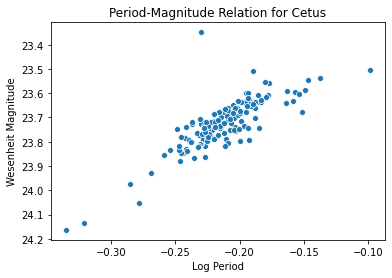

In [28]:
plt.figure()
sns.scatterplot(data = cetus_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Cetus');

In [29]:
tucana_path = os.path.join('Tucana', 'apj298915t8_mrt.txt')

tucana_names = ['Star', 'Type', 'RA (Hour)', 'RA (Min)', 'RA (Sec)', 'Dec (Deg)', 'Dec (Min)', 'Dec (Sec)',
                'Uncertainty Flag', 'Period (Days)', 'Log Period (Days)', 'F475W Magnitude', 'F475W Amplitude', 
                'F814W Magnitude', 'F814W Amplitude', 'Color', 'B Magnitude', 'B Amplitude', 
                'V Magnitude', 'V Amplitude', 'I Magnitude', 'I Amplitude']

tucana_graph_tab, tucana_lin_reg = convert_table(tucana_path, tucana_names, impute = True)

In [30]:
display(tucana_lin_reg.head())
tucana_lin_reg.to_csv('Monte Carlo/tucana_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V003,24.060043,0.03,-0.202732,0
1,V005,24.276053,0.03,-0.265200,1
2,V007,23.884150,0.03,-0.166853,2
3,V011,24.071952,0.03,-0.226214,3
4,V014,24.073906,0.03,-0.246417,4


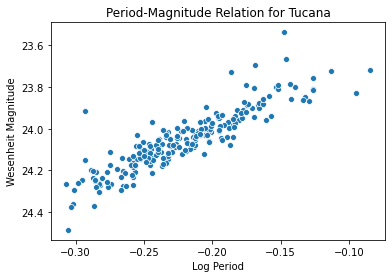

In [31]:
plt.figure()
sns.scatterplot(data = tucana_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Tucana');

# Application to Leo A and Leo I

In [32]:
leo_a_path = os.path.join('Leo', 'Leo_A_variables.dat')
leo_a_names = ['Star', 'Type', 'Period (Days)', 'V Magnitude', 'I Magnitude']
leo_a_graph_tab, leo_a_lin_reg = convert_table(leo_a_path, leo_a_names, usecols = [0, 1, 8, 17, 19])

In [33]:
display(leo_a_lin_reg.head())
leo_a_lin_reg.to_csv('Monte Carlo/leo_a_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.357739,0.03,-0.161151,0
1,V019,23.655627,0.03,-0.204120,1
2,V029,23.853053,0.03,-0.231362,2
3,V052,23.727206,0.03,-0.190440,3
4,V077,23.562013,0.03,-0.167491,4


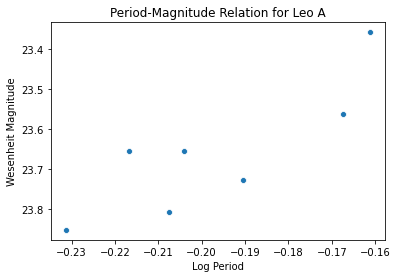

In [34]:
plt.figure()
sns.scatterplot(data = leo_a_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Leo A');

In [35]:
leo_i_path = os.path.join('Leo', 'Leo_I_variables.dat')

leo_i_names = ['Star', 'Type', 'Period (Days)', 'V Magnitude', 'I Magnitude', 'Quality']

leo_i_pulsation = pd.read_csv(leo_i_path, sep = '\s{1,}', header = None, names = leo_i_names, engine = 'python', 
                            usecols = [0, 1, 2, 4, 6, 11])

leo_i_pulsation = leo_i_pulsation[leo_i_pulsation['Quality'] == 'A'].drop({'Quality'}, axis = 1)
leo_i_pulsation = leo_i_pulsation[leo_i_pulsation['I Magnitude'] != '-'].astype({'I Magnitude' : 'float64'})

leo_i_pulsation.info()
leo_i_pulsation.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 6 to 158
Data columns (total 5 columns):
Star             80 non-null object
Type             80 non-null object
Period (Days)    80 non-null float64
V Magnitude      80 non-null float64
I Magnitude      80 non-null float64
dtypes: float64(3), object(2)
memory usage: 3.8+ KB


,Star,Type,Period (Days),V Magnitude,I Magnitude
6,V7,RRab,0.602402,22.75,22.25
8,V9,RRab,0.574817,22.69,22.34
21,V24,RRab,0.607729,22.78,22.25
26,V32,RRab,0.580355,22.66,22.27
28,V36,RRab,0.558055,22.70,22.23


In [36]:
leo_i_lin_reg = leo_i_pulsation[['Star', 'Type', 'V Magnitude', 'I Magnitude']]

leo_i_lin_reg['Wesenheit Magnitude'] = (leo_i_lin_reg['I Magnitude'] - 1.467 * 
                                     (leo_i_lin_reg['V Magnitude'] - leo_i_lin_reg['I Magnitude']))

leo_i_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

leo_i_lin_reg['Log Period'] = np.log10(leo_i_pulsation['Period (Days)'])

leo_i_graph_tab = leo_i_lin_reg.rename({'Type' : 'Variable Type'}, axis = 1)

leo_i_lin_reg = leo_i_lin_reg[leo_i_lin_reg['Type'] == 'RRab'].drop({'Type'}, axis = 1)

num_stars = len(leo_i_lin_reg['Star'].unique())
leo_i_lookup = dict(zip(leo_i_lin_reg['Star'].unique(), range(num_stars)))
leo_i_lin_reg['Star Code'] = leo_i_lin_reg['Star'].replace(leo_i_lookup).values

leo_i_lin_reg = leo_i_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]

leo_i_lin_reg = leo_i_lin_reg.reset_index().drop('index', axis = 1)

display(leo_i_lin_reg.head())
leo_i_lin_reg.to_csv('Monte Carlo/leo_i_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V7,21.51650,0.03,-0.220114,0
1,V9,21.82655,0.03,-0.240470,1
2,V24,21.47249,0.03,-0.216290,2
3,V32,21.69787,0.03,-0.236306,3
4,V36,21.54051,0.03,-0.253323,4


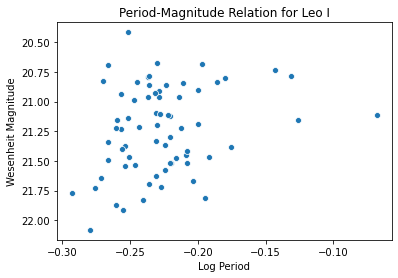

In [37]:
plt.figure()
sns.scatterplot(data = leo_i_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Leo I');

# Application to NGC 147 and 185

In [38]:
NGC_147_path = os.path.join('NGC 147 and 185', 'NGC_147.txt')
NGC_147_names = ['Star', 'RA Hour', 'RA Minute', 'RA Second', 'Dec Degree', 'Dec Minute', 'Dec Second', 'Period (Days)', 
                 'F606W Magnitude', 'F606W Amplitude', 'F814W Magnitude', 'F814W Amplitude', 'Color', 'Type']
NGC_147_graph_tab, NGC_147_lin_reg = convert_table(NGC_147_path, NGC_147_names, convert = 'hubble')

In [39]:
outlier_one = (NGC_147_graph_tab['Log Period'] < -0.2) & (NGC_147_graph_tab['Wesenheit Magnitude'] < 23.0)
outlier_two = (NGC_147_graph_tab['Log Period'] > -0.2) & (NGC_147_graph_tab['Wesenheit Magnitude'] > 23.7)
NGC_147_graph_tab['Outlier'] = outlier_one | outlier_two | (NGC_147_graph_tab['Log Period'] > 0.0)
display(NGC_147_graph_tab.head())

,Star,Variable Type,Period (Days),Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,V001,RRab,0.610,23.255885,0.03,-0.214670,False
1,V002,RRc,0.306,23.771914,0.03,-0.514279,False
2,V003,RRab,0.560,23.440229,0.03,-0.251812,False
3,V004,RRab,0.539,23.540294,0.03,-0.268411,False
4,V005,RRab,0.703,23.230241,0.03,-0.153045,False


In [40]:
bool_filter_one = NGC_147_graph_tab[NGC_147_graph_tab['Variable Type'] == 'RRab'].reset_index()['Outlier']
NGC_147_lin_reg = NGC_147_lin_reg.loc[~(bool_filter_one), :]
display(NGC_147_lin_reg.head())
NGC_147_lin_reg.to_csv('Monte Carlo/NGC_147_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.255885,0.03,-0.214670,0
1,V003,23.440229,0.03,-0.251812,1
2,V004,23.540294,0.03,-0.268411,2
3,V005,23.230241,0.03,-0.153045,3
4,V006,23.130767,0.03,-0.221126,4


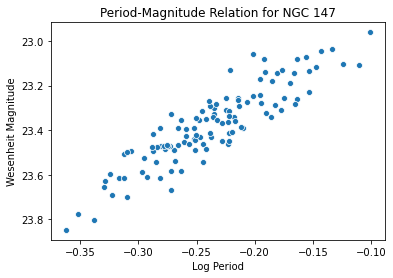

In [41]:
plt.figure()
sns.scatterplot(data = NGC_147_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 147');

In [42]:
NGC_185_path = os.path.join('NGC 147 and 185', 'NGC_185.txt')
NGC_185_graph_tab, NGC_185_lin_reg = convert_table(NGC_185_path, NGC_147_names, convert = 'hubble')

In [43]:
outlier_three = (NGC_185_graph_tab['Log Period'] < -0.25) & (NGC_185_graph_tab['Wesenheit Magnitude'] < 23.0)
outlier_four = (NGC_185_graph_tab['Wesenheit Magnitude'] < 22.55)
NGC_185_graph_tab['Outlier'] = outlier_three | outlier_four | (NGC_185_graph_tab['Log Period'] > 0.0)
display(NGC_185_graph_tab.head())

,Star,Variable Type,Period (Days),Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,V001,AC?,0.654,21.928430,0.03,-0.184422,True
1,V002,RRc,0.318,23.472728,0.03,-0.497573,False
2,V003,RRc,0.264,23.567945,0.03,-0.578396,False
3,V004,RRc,0.351,23.149115,0.03,-0.454693,False
4,V005,RRab,0.643,22.856055,0.03,-0.191789,False


In [44]:
bool_filter_two = NGC_185_graph_tab[NGC_185_graph_tab['Variable Type'] == 'RRab'].reset_index()['Outlier']
NGC_185_lin_reg = NGC_185_lin_reg.loc[~(bool_filter_two), :]
display(NGC_185_lin_reg.head())
NGC_185_lin_reg.to_csv('Monte Carlo/NGC_185_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V005,22.856055,0.03,-0.191789,0
1,V009,23.341186,0.03,-0.322393,1
2,V010,23.289632,0.03,-0.310691,2
3,V013,23.111675,0.03,-0.232844,3
4,V014,23.231663,0.03,-0.308919,4


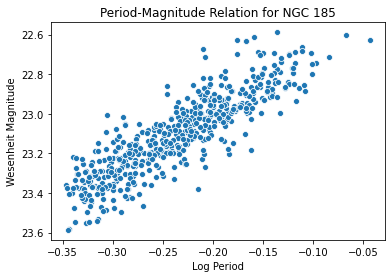

In [45]:
plt.figure()
sns.scatterplot(data = NGC_185_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 185');

# Application to Fornax

In [46]:
fornax_path = os.path.join('Fornax', 'fornax_catalog.csv')
fornax_names = ['Star', 'g Magnitude', 'r Magnitude', 'i Magnitude', 'z Magnitude', 'Period (Days)', 'Type']
fornax_graph_tab, fornax_lin_reg = convert_table(fornax_path, fornax_names, usecols = [0, 8, 9, 10, 11, 14, 37], sep = ',',
                                                 convert = 'des')

In [47]:
fornax_graph_tab = fornax_graph_tab.dropna()
fornax_graph_tab['Star'] = np.array(['Star ' + elem for elem in np.array(list(range(len(fornax_graph_tab)))).astype(str)])
outlier_fornax = ((fornax_graph_tab['Log Period'] < -0.3) | (fornax_graph_tab['Log Period'] > -0.05) 
                  | (fornax_graph_tab['Wesenheit Magnitude'] < 19.0))
fornax_graph_tab['Outlier'] = outlier_fornax
fornax_graph_tab.head()

,Star,Variable Type,Period (Days),Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,Star 0,ab,0.578921,19.983004,0.03,-0.237380,False
1,Star 1,ab,0.601540,20.102479,0.03,-0.220736,False
2,Star 2,ab,0.612595,20.157855,0.03,-0.212827,False
3,Star 3,ab,0.581395,19.934078,0.03,-0.235528,False
4,Star 4,ab,0.569833,20.163488,0.03,-0.244252,False


In [48]:
fornax_lin_reg = fornax_lin_reg.dropna()
fornax_lin_reg['Star'] = np.array(['Star ' + elem for elem in np.array(list(range(len(fornax_lin_reg)))).astype(str)])
fornax_lin_reg = fornax_lin_reg.loc[~(fornax_graph_tab['Outlier']), :]
display(fornax_lin_reg.head())
fornax_lin_reg.to_csv('Monte Carlo/fornax_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,Star 0,19.983004,0.03,-0.237380,0
1,Star 1,20.102479,0.03,-0.220736,1
2,Star 2,20.157855,0.03,-0.212827,2
3,Star 3,19.934078,0.03,-0.235528,3
4,Star 4,20.163488,0.03,-0.244252,4


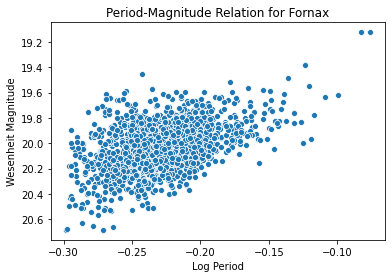

In [49]:
plt.figure()
sns.scatterplot(data = fornax_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Fornax');

# Application to ESO294-G010 and ESO410-G005

In [102]:
def eso_analysis(path):
    """Converts photometric data to desired format for MCMC model."""

    names = ['Type', 'Star', 'V Magnitude', 'Color', 'Period (Days)']
    pulsation = pd.read_csv(path, header = None, names = names, usecols = [0, 2, 9, 10, 11], sep = '\s{1,}', engine = 'python')
    pulsation['I Magnitude'] = pulsation['V Magnitude'] - pulsation['Color']
    
    lin_reg = pulsation[['Star', 'V Magnitude', 'I Magnitude', 'Color', 'Period (Days)', 'Type']]

    lin_reg['Wesenheit Magnitude'] = lin_reg['I Magnitude'] - 1.467 * lin_reg['Color']
    lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

    lin_reg['Log Period'] = np.log10(lin_reg['Period (Days)'])

    num_stars = len(lin_reg['Star'].unique())
    lookup = dict(zip(lin_reg['Star'].unique(), range(num_stars)))
    lin_reg['Star Code'] = lin_reg['Star'].replace(lookup).values

    lin_reg = lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 
                                   'Log Period', 'Star Code', 'Type']]

    graph_tab = lin_reg.copy()
    graph_tab['Star'] = np.array(['Star ' + elem for elem in np.array(list(range(len(graph_tab)))).astype(str)])

    lin_reg =  lin_reg[lin_reg['Type'] == 'RRab'].reset_index().drop(['index', 'Type'], axis = 1)
    lin_reg['Star'] = np.array(['Star ' + elem for elem in np.array(list(range(len(lin_reg)))).astype(str)])
    
    return graph_tab, lin_reg

In [103]:
ESO_294_path = os.path.join('ESO', 'ESO294-G010.txt')
ESO_294_graph_tab, ESO_294_lin_reg = eso_analysis(ESO_294_path)
display(ESO_294_lin_reg.head())
ESO_294_lin_reg.to_csv('Monte Carlo/eso_294_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,Star 0,25.734084,0.03,-0.283997,0
1,Star 1,25.853454,0.03,-0.170053,1
2,Star 2,25.787002,0.03,-0.189029,2
3,Star 3,25.390181,0.03,-0.305307,3
4,Star 4,25.631389,0.03,-0.226799,4


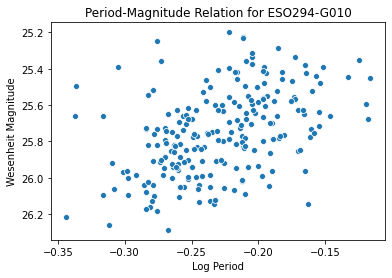

In [104]:
plt.figure()
sns.scatterplot(data = ESO_294_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for ESO294-G010');

In [105]:
ESO_410_path = os.path.join('ESO', 'ESO410-G005.txt')
ESO_410_graph_tab, ESO_410_lin_reg = eso_analysis(ESO_410_path)
display(ESO_410_lin_reg.head())
ESO_410_lin_reg.to_csv('Monte Carlo/eso_410_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,Star 0,25.705094,0.03,-0.249955,0
1,Star 1,25.260988,0.03,-0.172760,1
2,Star 2,25.684246,0.03,-0.164246,2
3,Star 3,25.780596,0.03,-0.226726,3
4,Star 4,25.909596,0.03,-0.243592,4


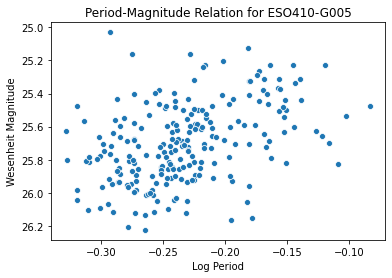

In [106]:
plt.figure()
sns.scatterplot(data = ESO_410_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for ESO410-G005');

# Application to Phoenix

In [107]:
phoenix_path = os.path.join('Phoenix', 'phoenix.txt')
phoenix_names = ['Star', 'Type', 'Period (Days)', 'V Magnitude', 'I Magnitude']
phoenix_graph_tab, phoenix_lin_reg = convert_table(phoenix_path, phoenix_names, usecols = [0, 7, 8, 11, 12])

In [108]:
display(phoenix_lin_reg.head())
phoenix_lin_reg.to_csv('Monte Carlo/phoenix_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V00030,22.691429,0.03,-0.259637,0
1,V01828,22.501165,0.03,-0.238824,1
2,V01851,22.252262,0.03,-0.182435,2
3,V01852,22.689393,0.03,-0.259637,3
4,V01862,22.395140,0.03,-0.221849,4


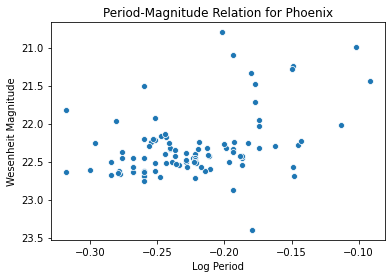

In [109]:
plt.figure()
sns.scatterplot(data = phoenix_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Phoenix');

# Application to Globular Clusters

In [50]:
NGC_5824_path = os.path.join('Globular Clusters', 'NGC5824.csv')

NGC_5824_names = ['Star', 'Type', 'Period (Days)', 'B Magnitude', 'V Magnitude', 'I Magnitude']

NGC_5824_pulsation = pd.read_csv(NGC_5824_path, header = None, names = NGC_5824_names)

NGC_5824_pulsation.info()
NGC_5824_pulsation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
Star             59 non-null object
Type             59 non-null object
Period (Days)    59 non-null object
B Magnitude      59 non-null float64
V Magnitude      59 non-null float64
I Magnitude      59 non-null float64
dtypes: float64(3), object(3)
memory usage: 2.8+ KB


,Star,Type,Period (Days),B Magnitude,V Magnitude,I Magnitude
0,V1,RRab,0.597259,18.80,18.37,17.77
1,V2,RRab,0.649413,18.85,18.39,17.75
2,V3,RRab,0.732079,18.90,18.30,17.60
3,V4,RRc,0.334383,18.80,18.40,17.86
4,V5,RRab,0.630958,18.88,18.37,17.71


In [51]:
NGC_5824_lin_reg = NGC_5824_pulsation[NGC_5824_pulsation['Type'] == 'RRab'].reset_index().drop(['index', 'Type'], axis = 1)
NGC_5824_lin_reg = NGC_5824_lin_reg.astype({'Period (Days)' : 'float64'})

NGC_5824_lin_reg['Wesenheit Magnitude'] = (NGC_5824_lin_reg['I Magnitude'] - 1.467 * 
                                           (NGC_5824_lin_reg['V Magnitude'] - NGC_5824_lin_reg['I Magnitude']))

NGC_5824_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

NGC_5824_lin_reg['Log Period'] = np.log10(NGC_5824_lin_reg['Period (Days)'])

NGC_5824_lin_reg = NGC_5824_lin_reg[NGC_5824_lin_reg['Wesenheit Magnitude'] > 16.4]

num_stars = len(NGC_5824_lin_reg['Star'].unique())
NGC_5824_lookup = dict(zip(NGC_5824_lin_reg['Star'].unique(), range(num_stars)))
NGC_5824_lin_reg['Star Code'] = NGC_5824_lin_reg['Star'].replace(NGC_5824_lookup).values

NGC_5824_lin_reg = NGC_5824_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 
                                     'Log Period', 'Star Code']]

NGC_5824_lin_reg = NGC_5824_lin_reg.reset_index().drop('index', axis = 1)

display(NGC_5824_lin_reg.head())
NGC_5824_lin_reg.to_csv('Monte Carlo/NGC_5824_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,16.88980,0.03,-0.223837,0
1,V2,16.81112,0.03,-0.187479,1
2,V3,16.57310,0.03,-0.135442,2
3,V5,16.74178,0.03,-0.200000,3
4,V8,16.77178,0.03,-0.220853,4


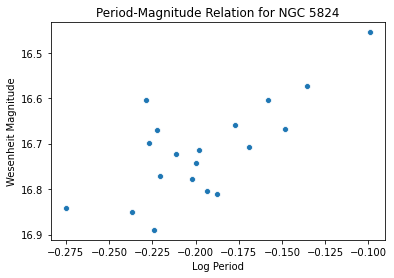

In [52]:
plt.figure()
sns.scatterplot(data = NGC_5824_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 5824');

In [53]:
M4_path = os.path.join('Globular Clusters', 'M4.txt')

M4_names = ['Star', 'Period (Days)', 'U Magnitude', 'B Magnitude', 'V Magnitude', 'R Magnitude', 'I Magnitude', 
            'U Amplitude', 'B Amplitude', 'V Amplitude', 'R Amplitude', 'I Amplitude', 'Type']

M4_pulsation = pd.read_csv(M4_path, sep = '\s{1,}', header = None, names = M4_names, engine = 'python')
M4_pulsation.head()

,Star,Period (Days),U Magnitude,B Magnitude,V Magnitude,R Magnitude,I Magnitude,U Amplitude,B Amplitude,V Amplitude,R Amplitude,I Amplitude,Type
0,V1,0.288883,14.56,14.02,13.43,13.00,12.54,0.44,0.57,0.44,0.36,0.24,RRc
1,V2,0.535682,14.50,14.12,13.41,12.91,12.39,1.09,1.26,0.96,0.76,0.61,RRab*
2,V3,0.506678,14.71,13.65,13.01,â€”,12.28,â€”,0.99,â€”,â€”,â€”,RRab
3,V5,0.622401,14.57,14.12,13.37,12.84,12.28,â€”,0.43,0.33,0.26,0.20,RRab
4,V6,0.320515,14.41,14.08,13.45,13.00,12.50,0.63,0.56,0.43,0.35,0.25,RRc


In [54]:
M4_lin_reg = M4_pulsation[['Star', 'Type', 'Period (Days)', 'B Magnitude', 'V Magnitude', 'I Magnitude']]

M4_lin_reg = M4_lin_reg[M4_lin_reg['Type'] == 'RRab'].reset_index().drop(['index', 'Type'], axis = 1)
M4_lin_reg = M4_lin_reg.astype({'Period (Days)' : 'float64', 'V Magnitude' : 'float64', 'I Magnitude' : 'float64'})

M4_lin_reg['Wesenheit Magnitude'] = (M4_lin_reg['I Magnitude'] - 1.467 * 
                                     (M4_lin_reg['V Magnitude'] - M4_lin_reg['I Magnitude']))

M4_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

M4_lin_reg['Log Period'] = np.log10(M4_lin_reg['Period (Days)'])

M4_lin_reg = M4_lin_reg[M4_lin_reg['Wesenheit Magnitude'] < 13.0]

num_stars = len(M4_lin_reg['Star'].unique())
M4_lookup = dict(zip(M4_lin_reg['Star'].unique(), range(num_stars)))
M4_lin_reg['Star Code'] = M4_lin_reg['Star'].replace(M4_lookup).values

M4_lin_reg = M4_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]

M4_lin_reg = M4_lin_reg.reset_index().drop('index', axis = 1)

display(M4_lin_reg.head())
M4_lin_reg.to_csv('Monte Carlo/M4_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V3,11.20909,0.03,-0.295268,0
1,V5,10.68097,0.03,-0.205930,1
2,V7,10.90366,0.03,-0.302085,2
3,V8,10.87767,0.03,-0.293945,3
4,V9,10.83300,0.03,-0.242684,4


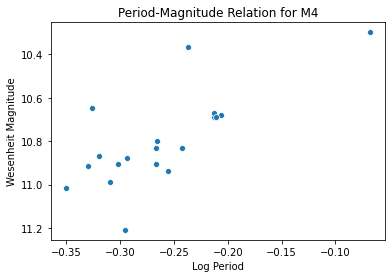

In [55]:
plt.figure()
sns.scatterplot(data = M4_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for M4');

In [56]:
NGC_362_path = os.path.join('Globular Clusters', 'NGC362.txt')

NGC_362_names = ['Star', 'RA', 'Dec', 'Period (Days)', 'V Magnitude', 'Color (V - I)', 'Amplitude', 'Epoch', 'Type']

NGC_362_pulsation = pd.read_csv(NGC_362_path, sep = '\s{1,}', header = None, names = NGC_362_names, engine = 'python')
NGC_362_pulsation.head()

,Star,RA,Dec,Period (Days),V Magnitude,Color (V - I),Amplitude,Epoch,Type
0,V6,1:01:49.14,âˆ’71:07:36.9,0.30250,18.96,0.71,1.07,3284.1702,RRab
1,V7,1:01:54.55,âˆ’70:46:59.7,0.54753,15.80,-0.12,1.32,2854.2440,RRab
2,V8,1:01:56.71,âˆ’71:10:00.2,0.29218,19.33,0.83,0.98,3284.1647,RRab
3,V15,1:02:24.02,âˆ’70:51:56.4,0.58506,15.55,0.58,0.91,2927.0715,RRab
4,V16,1:02:24.06,âˆ’71:05:13.5,0.59339,16.47,0.11,0.25,2927.1882,RRc


In [57]:
NGC_362_lin_reg = NGC_362_pulsation[['Star', 'Type', 'Period (Days)', 'V Magnitude', 'Color (V - I)']]

NGC_362_lin_reg = NGC_362_lin_reg[NGC_362_lin_reg['Type'] == 'RRab'].reset_index().drop(['index', 'Type'], axis = 1)
NGC_362_lin_reg = NGC_362_lin_reg.astype({'Period (Days)' : 'float64', 'V Magnitude' : 'float64', 'Color (V - I)' : 'float64'})

NGC_362_lin_reg['Wesenheit Magnitude'] = ((NGC_362_lin_reg['V Magnitude'] - NGC_362_lin_reg['Color (V - I)']) 
                                          - 1.467 * NGC_362_lin_reg['Color (V - I)'])

NGC_362_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

NGC_362_lin_reg['Log Period'] = np.log10(NGC_362_lin_reg['Period (Days)'])

num_stars = len(NGC_362_lin_reg['Star'].unique())
NGC_362_lookup = dict(zip(NGC_362_lin_reg['Star'].unique(), range(num_stars)))
NGC_362_lin_reg['Star Code'] = NGC_362_lin_reg['Star'].replace(NGC_362_lookup).values

NGC_362_lin_reg = NGC_362_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]

NGC_362_lin_reg = NGC_362_lin_reg.reset_index().drop('index', axis = 1)

display(NGC_362_lin_reg.head())
NGC_362_lin_reg.to_csv('Monte Carlo/NGC_362_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V6,17.20843,0.03,-0.519275,0
1,V7,16.09604,0.03,-0.261592,1
2,V8,17.28239,0.03,-0.534350,2
3,V15,14.11914,0.03,-0.232800,3
4,V27,14.41452,0.03,-0.309724,4


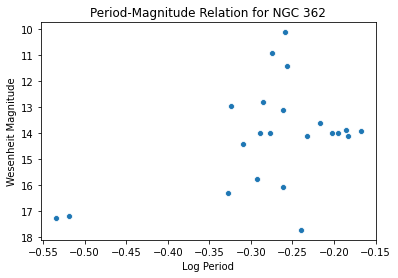

In [58]:
plt.figure()
sns.scatterplot(data = NGC_362_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 362');

# Application to Milky Way Field RR Lyrae

In [59]:
# Data from Neeley et al. (2019)
mw_info = pd.read_csv('Milky Way/field_pulsation.csv')
mw_info.head()

,Star,Period (Days),Class,Metallicity
0,AB UMa,0.599581,RRab,-0.49
1,AE Boo,0.314890,RRc,-1.39
2,AM Tuc,0.405802,RRc,-1.49
3,AN Ser,0.522071,RRab,-0.07
4,AP Ser,0.340830,RRc,-1.58


In [60]:
mw_mags = pd.read_csv('Milky Way/field_magnitudes.csv')
mw_mags.head()

,Star,Mean B Magnitude,Uncertainty in Mean B Magnitude,Mean V Magnitude,Uncertainty in Mean V Magnitude,Mean I Magnitude,Uncertainty in Mean I Magnitude
0,AB UMa,11.359,0.009,10.912,0.009,10.342,0.009
1,AE Boo,10.887,0.009,10.640,0.009,10.254,0.009
2,AM Tuc,11.918,0.006,11.626,0.006,11.188,0.006
3,AN Ser,11.321,0.008,10.935,0.008,10.446,0.008
4,AP Ser,11.368,0.008,11.129,0.008,10.765,0.008


In [61]:
mw_complete = mw_info.copy()
mw_complete['Log Period'] = np.log10(mw_complete['Period (Days)'])

mw_complete = mw_complete.reset_index().drop(['index', 'Class', 'Period (Days)'], axis = 1)

mw_num_stars = len(mw_complete['Star'].unique())
mw_lookup = dict(zip(mw_complete['Star'].unique(), range(mw_num_stars)))
mw_complete['Star Code'] = mw_complete['Star'].replace(mw_lookup).values

mw_complete.info()
display(mw_complete.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 4 columns):
Star           55 non-null object
Metallicity    55 non-null float64
Log Period     55 non-null float64
Star Code      55 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ KB


,Star,Metallicity,Log Period,Star Code
0,AB UMa,-0.49,-0.222152,0
1,AE Boo,-1.39,-0.501841,1
2,AM Tuc,-1.49,-0.391686,2
3,AN Ser,-0.07,-0.282270,3
4,AP Ser,-1.58,-0.467462,4


In [62]:
mw_lin_reg = mw_info.copy()
mw_lin_reg['Log Period'] = np.log10(mw_lin_reg['Period (Days)'])

mw_lin_reg = mw_lin_reg[mw_lin_reg['Class'] == 'RRab'].reset_index().drop(['index', 'Class', 'Period (Days)'], axis = 1)

mw_num_stars = len(mw_lin_reg['Star'].unique())
mw_lookup = dict(zip(mw_lin_reg['Star'].unique(), range(mw_num_stars)))
mw_lin_reg['Star Code'] = mw_lin_reg['Star'].replace(mw_lookup).values

mw_lin_reg.info()
display(mw_lin_reg.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 4 columns):
Star           37 non-null object
Metallicity    37 non-null float64
Log Period     37 non-null float64
Star Code      37 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.2+ KB


,Star,Metallicity,Log Period,Star Code
0,AB UMa,-0.49,-0.222152,0
1,AN Ser,-0.07,-0.282270,1
2,AV Peg,-0.08,-0.408518,2
3,BB Pup,-0.60,-0.318262,3
4,BH Peg,-1.22,-0.193147,4


In [63]:
mw_parallaxes = pd.read_csv('Milky Way/field_parallax.csv')

mw_parallaxes['Distance Modulus'] = 5 * np.log10(100 / mw_parallaxes['Parallax (mas)'])
mw_parallaxes['Uncertainty in Distance Modulus'] = ((5 / np.log(10)) * 
                                                    (mw_parallaxes['Parallax Error (mas)'] / mw_parallaxes['Parallax (mas)']))

mw_parallaxes.head()

,Star,Parallax (mas),Parallax Error (mas),E(B - V),Distance Modulus,Uncertainty in Distance Modulus
0,AB UMa,1.01,0.03,0.022,9.978393,0.064499
1,AE Boo,1.17,0.04,0.023,9.659071,0.074238
2,AM Tuc,0.57,0.03,0.023,11.220626,0.114288
3,AN Ser,0.98,0.04,0.040,10.043870,0.088632
4,AP Ser,0.78,0.04,0.042,10.539527,0.111358


In [64]:
def conv_to_abs_V(app):
    return app - mw_parallaxes['Distance Modulus'] - 3.128 * mw_parallaxes['E(B - V)']

def conv_to_abs_B(app):
    return app - mw_parallaxes['Distance Modulus'] - 4.151 * mw_parallaxes['E(B - V)']

def conv_to_abs_I(app):
    return app - mw_parallaxes['Distance Modulus'] - 1.860 * mw_parallaxes['E(B - V)']

app_mags = (mw_mags['Mean I Magnitude'] - 1.467 * (mw_mags['Mean V Magnitude'] - mw_mags['Mean I Magnitude']))

app_unc = (mw_mags['Uncertainty in Mean I Magnitude'] - 1.467 * (mw_mags['Uncertainty in Mean V Magnitude'] 
                                                                 - mw_mags['Uncertainty in Mean I Magnitude']))

abs_mags = (conv_to_abs_I(mw_mags['Mean I Magnitude']) - 1.467 * (conv_to_abs_V(mw_mags['Mean V Magnitude']) 
                                                                 - conv_to_abs_I(mw_mags['Mean I Magnitude'])))

mw_parallaxes['Apparent Wesenheit Magnitude'] = app_mags
mw_parallaxes['Absolute Wesenheit Magnitude'] = abs_mags
mw_parallaxes['Uncertainty in Apparent Wesenheit Magnitude'] = app_unc

mw_parallaxes.head()

,Star,Parallax (mas),Parallax Error (mas),E(B - V),Distance Modulus,Uncertainty in Distance Modulus,Apparent Wesenheit Magnitude,Absolute Wesenheit Magnitude,Uncertainty in Apparent Wesenheit Magnitude
0,AB UMa,1.01,0.03,0.022,9.978393,0.064499,9.505810,-0.472580,0.009
1,AE Boo,1.17,0.04,0.023,9.659071,0.074238,9.687738,0.028671,0.009
2,AM Tuc,0.57,0.03,0.023,11.220626,0.114288,10.545454,-0.675168,0.006
3,AN Ser,0.98,0.04,0.040,10.043870,0.088632,9.728637,-0.315226,0.008
4,AP Ser,0.78,0.04,0.042,10.539527,0.111358,10.231012,-0.308508,0.008


In [65]:
mw_complete['Wesenheit Magnitude'] = np.array(mw_parallaxes['Apparent Wesenheit Magnitude'])

mw_complete['Uncertainty in Wesenheit Magnitude'] = np.array(mw_parallaxes['Uncertainty in Apparent Wesenheit Magnitude'])

mw_complete['Distance Modulus'] = (np.array(mw_parallaxes['Apparent Wesenheit Magnitude']) - 
                                  np.array(mw_parallaxes['Absolute Wesenheit Magnitude']))

mw_complete['Uncertainty in Distance Modulus'] = np.array(mw_parallaxes['Uncertainty in Distance Modulus'])

mw_complete.loc[mw_info['Class'] == 'RRc', 'Log Period'] = np.array(mw_complete[mw_info['Class'] 
                                                                                == 'RRc']['Log Period']) + 0.127

mw_complete = mw_complete[['Star', 'Log Period', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                         'Distance Modulus', 'Uncertainty in Distance Modulus', 'Metallicity', 'Star Code']]

display(mw_complete.head())

mw_complete.to_csv('Monte Carlo/milky_way_complete_mcmc.csv')

,Star,Log Period,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Distance Modulus,Uncertainty in Distance Modulus,Metallicity,Star Code
0,AB UMa,-0.222152,9.505810,0.009,9.978390,0.064499,-0.49,0
1,AE Boo,-0.374841,9.687738,0.009,9.659067,0.074238,-1.39,1
2,AM Tuc,-0.264686,10.545454,0.006,11.220622,0.114288,-1.49,2
3,AN Ser,-0.282270,9.728637,0.008,10.043863,0.088632,-0.07,3
4,AP Ser,-0.340462,10.231012,0.008,10.539520,0.111358,-1.58,4


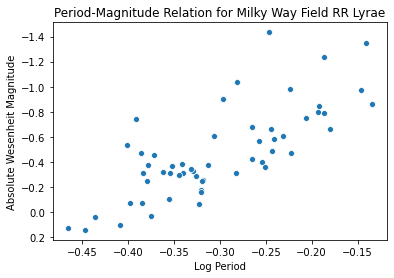

In [66]:
plt.figure()
sns.scatterplot(x = mw_complete['Log Period'], y = mw_complete['Wesenheit Magnitude'] - mw_complete['Distance Modulus'])
plt.gca().invert_yaxis()
plt.ylabel('Absolute Wesenheit Magnitude')
plt.title(f'Period-Magnitude Relation for Milky Way Field RR Lyrae');

In [67]:
filt_mw_parallaxes = mw_parallaxes[mw_parallaxes['Star'].isin(mw_lin_reg['Star'].unique())]

mw_lin_reg['Wesenheit Magnitude'] = np.array(filt_mw_parallaxes['Apparent Wesenheit Magnitude'])

mw_lin_reg['Uncertainty in Wesenheit Magnitude'] = np.array(filt_mw_parallaxes['Uncertainty in Apparent Wesenheit Magnitude'])

mw_lin_reg['Distance Modulus'] = (np.array(filt_mw_parallaxes['Apparent Wesenheit Magnitude']) - 
                                  np.array(filt_mw_parallaxes['Absolute Wesenheit Magnitude']))

mw_lin_reg['Uncertainty in Distance Modulus'] = np.array(filt_mw_parallaxes['Uncertainty in Distance Modulus'])

mw_lin_reg = mw_lin_reg[['Star', 'Log Period', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                         'Distance Modulus', 'Uncertainty in Distance Modulus', 'Metallicity', 'Star Code']]

display(mw_lin_reg.head())

mw_lin_reg.to_csv('Monte Carlo/milky_way_mcmc.csv')

,Star,Log Period,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Distance Modulus,Uncertainty in Distance Modulus,Metallicity,Star Code
0,AB UMa,-0.222152,9.505810,0.009,9.978390,0.064499,-0.49,0
1,AN Ser,-0.282270,9.728637,0.008,10.043863,0.088632,-0.07,1
2,AV Peg,-0.408518,9.237500,0.008,9.134058,0.043721,-0.08,2
3,BB Pup,-0.318262,10.784881,0.007,11.038025,0.140095,-0.60,3
4,BH Peg,-0.193147,8.913729,0.005,9.715464,0.076192,-1.22,4


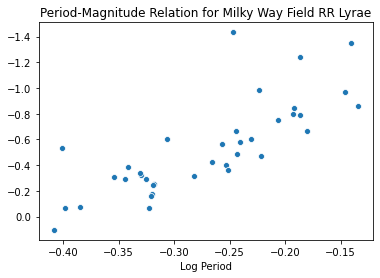

In [68]:
plt.figure()
sns.scatterplot(x = mw_lin_reg['Log Period'], y = mw_lin_reg['Wesenheit Magnitude'] - mw_lin_reg['Distance Modulus'])
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Milky Way Field RR Lyrae');

# Period-Wesenheit Magnitude-Metallicity Relationship

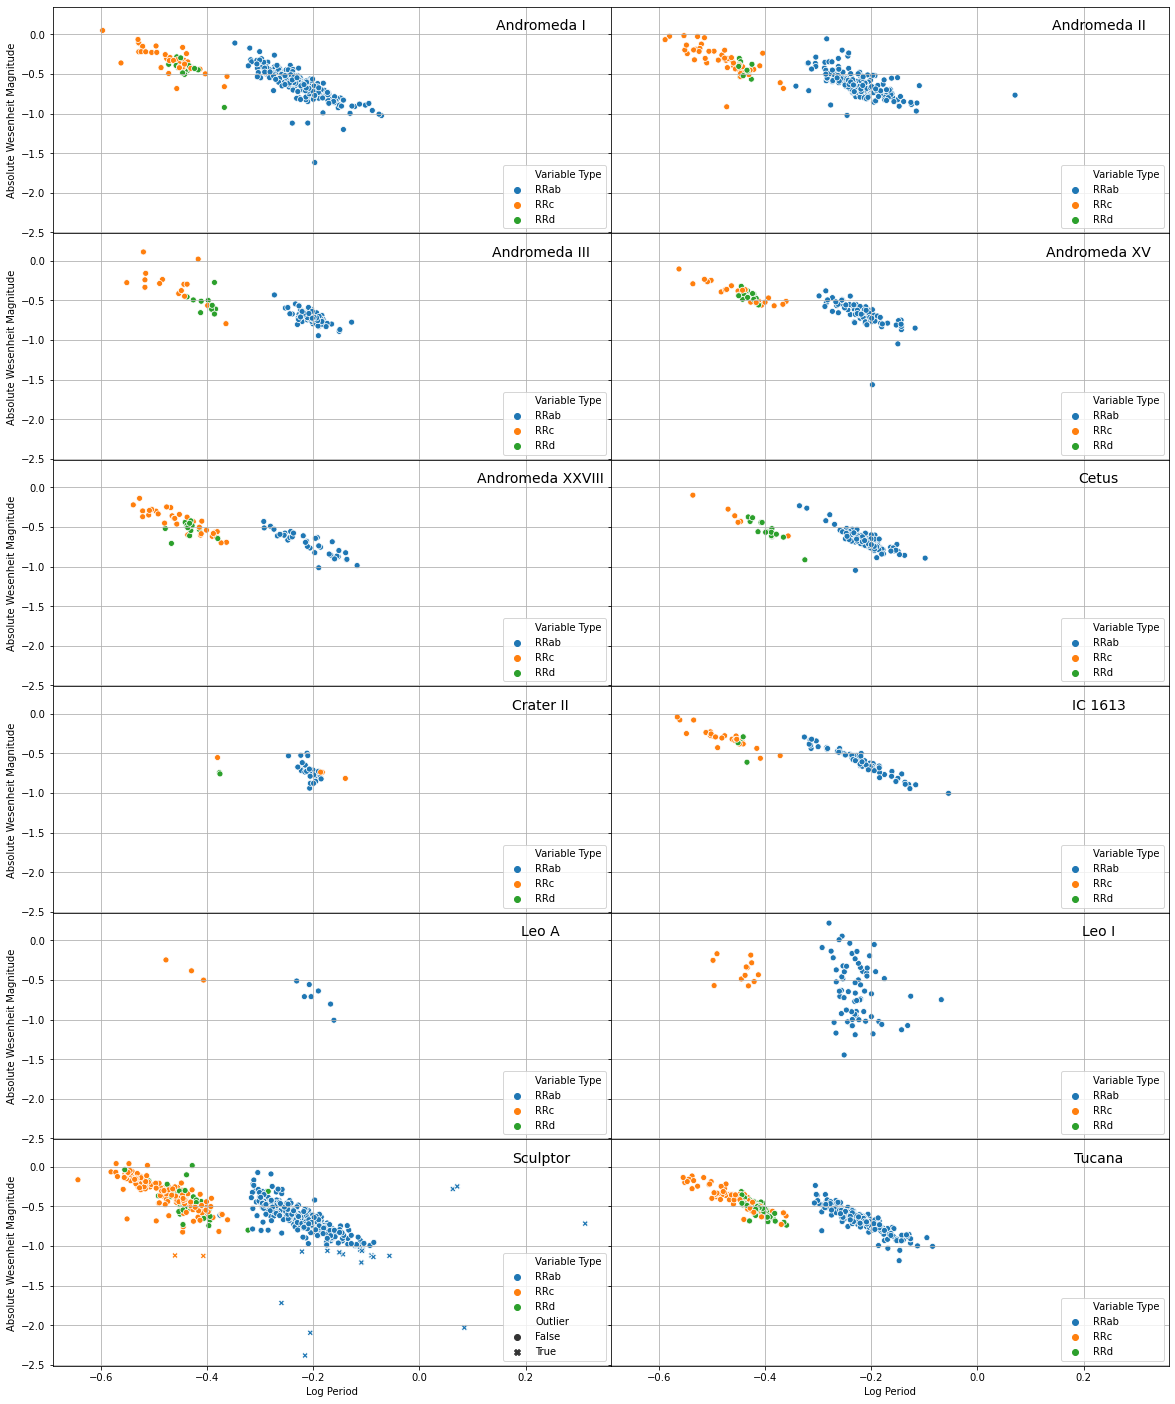

In [69]:
fig, ax = plt.subplots(6, 2, figsize = (20, 25), sharex = True, sharey = True, gridspec_kw = {'wspace' : 0, 'hspace' : 0})
data_repo = [and_one_graph_tab, and_two_graph_tab, and_three_graph_tab, and_fifteen_graph_tab, and_twenty_eight_graph_tab, 
             cetus_graph_tab,  crater_graph_tab, ic_graph_tab, leo_a_graph_tab, leo_i_graph_tab, sculptor_graph_tab, 
             tucana_graph_tab]
galaxy_names = ['Andromeda I', 'Andromeda II', 'Andromeda III', 'Andromeda XV', 'Andromeda XXVIII', 'Cetus', 'Crater II', 
                'IC 1613', 'Leo A', 'Leo I', 'Sculptor', 'Tucana']
mean_mods = np.loadtxt('moduli.txt')

for data in [cetus_graph_tab, ic_graph_tab, leo_a_graph_tab, tucana_graph_tab]:
    data.loc[:, 'Variable Type'] = data['Variable Type'].replace({'ab' : 'RRab', 'c' : 'RRc', 'd' : 'RRd'})

for i in range(len(data_repo)):
    data_repo[i] = data_repo[i][data_repo[i]['Variable Type'].isin(np.array(['RRab', 'RRc', 'RRd']))]

for i in range(6):
    for j in range(2):
        lin_tab = data_repo[2*i + j].copy()
        mean_tab = mean_mods[2*i + j] * np.ones(len(lin_tab))
        lin_tab['Absolute Wesenheit Magnitude'] = lin_tab['Wesenheit Magnitude'] - mean_tab
        if 'Outlier' in lin_tab.columns:
            sns.scatterplot(data = lin_tab, x = 'Log Period', y = 'Absolute Wesenheit Magnitude', 
                            hue = 'Variable Type', hue_order = ['RRab', 'RRc', 'RRd'], 
                            style = 'Outlier', ax = ax[i][j])
        else:
            sns.scatterplot(data = lin_tab, x = 'Log Period', y = 'Absolute Wesenheit Magnitude', 
                            hue = 'Variable Type', hue_order = ['RRab', 'RRc', 'RRd'], ax = ax[i][j])
        ax[i][j].invert_yaxis()
        ax[i][j].grid()
        ax[i][j].legend(loc = 'lower right')
        ax[i][j].text(0.875, 0.915, f'{galaxy_names[2*i + j]}', horizontalalignment='center', verticalalignment='center', 
                      transform=ax[i][j].transAxes, fontsize = 14);